# Zadanie

Dobrze byłoby wiedzieć czy dana sesja użytkownika zakończy się zakupem.

# Definicja problemu biznesowego

Użytkownicy odwiedzają naszą stronę w poszukiwaniu przedmiotów do kupienia lub zaglądają na nią po prostu z ciekawości. 
Jedynie część tych odwiedzin jest finalizowana zakupem.
Pozostała część kończy się na przejrzeniu oferty naszego serwisu i nie generuje żadnych zysków.
Zarząd spółki chce zwiększyć współczynnik konwersji, kierując odpowiednie reklamy i promocje do użytkowników, którzy są aktualnie w naszym sklepie i których prawdopodobieństwo zakupu naszego produktu jest wysokie.

# Definicja zadania modelowania

Przewidzieć na podstawie dostępnych danych, czy użytkownik o danej sesji dokona w ramach niej zakupu.
Stworzyć model klasyfikujący daną sesję do sesji zakończonych zakupem lub niezakończonych zakupem.

# Dane

W tej sekcji przedstawiona została ocena przydatności danych.
Zamieszczone podstawowe wizualizacje danych służą do lepszego zrozumienia kontekstu biznesowego sklepu, jego użytkowników i asortymentu.
Dokładna analiza danych i ich błędów jest zawarta w pliku <code>exploration</code>

In [1]:
import pandas as pd
import seaborn as sns; sns.set(rc={'figure.figsize':(16,9)})

## Użytkownicy

In [2]:
users = pd.read_json('data/users.jsonl', lines=True)
users.head()

,user_id,name,city,street
0,102,Juliusz Męcik,Warszawa,plac Krakowska 69
1,103,Eliza Miętka,Radom,ul. Bursztynowa 56/10
2,104,Kacper Kolarz,Warszawa,plac Wiślana 99
3,105,Tobiasz Radko,Gdynia,ulica Zwycięstwa 76/98
4,106,Roksana Merchel,Kutno,plac Głogowa 53/95


### Gdzie mieszkają użytkownicy?

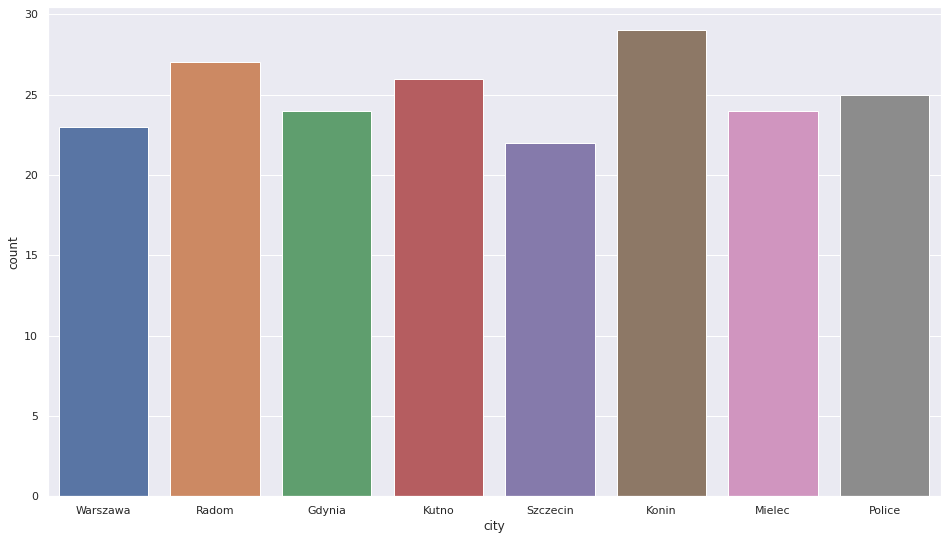

In [3]:
sns.countplot(x='city', data=users[['city', 'user_id']])

Miejsce zamieszkania użytkowników jest zróżnicowane, bez widocznej przewagi któregoś z miast. Są to zarówno ośrodki wielkomiejskie (Warszawa, Gdynia, Szczecin), jak i średnie lub małe miasta. Dane dotyczące użytkowników mogą okazać się przydatne, ponieważ na podstawie miejsca zamieszkania można oszacować zamożność klienta.
Dane te dostarczają również informacje o płci użytkownika, co może okazać się informatywne w przypadku przewidywania jego zakupu.

## Produkty

In [4]:
products = raw_products = pd.read_json('data/products.jsonl', lines=True)
categories = products.category_path.apply(lambda s: s.split(';')).apply(pd.Series)
categories = categories.rename(columns = lambda x : 'cat_' + str(x))
products = pd.concat([products, categories], axis=1).drop('category_path', axis=1)
products.head()

,product_id,product_name,price,cat_0,cat_1,cat_2,cat_3
0,1001,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria,Telefony stacjonarne,NaN,NaN
1,1002,Kyocera FS-1135MFP,2048.50,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN
2,1003,Kyocera FS-3640MFP,7639.00,Komputery,Drukarki i skanery,Biurowe urządzenia wielofunkcyjne,NaN
3,1004,Fallout 3 (Xbox 360),49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),49.99,Gry i konsole,Gry na konsole,Gry Xbox 360,NaN


### Cenowe anomalie

In [5]:
products[products.price > 1e7]

,product_id,product_name,price,cat_0,cat_1,cat_2,cat_3
88,1089,Rayman Origins (PC),3.790000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
92,1093,Company of Heroes 2 (PC),3.499000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
97,1098,DIRT 3 (PC),1.690000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
126,1127,Dark Void (PC),4.100000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
153,1154,Civilization 4 (PC),4.090000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
206,1207,LEGO Batman (PC),2.499000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
224,1225,Tygrysek i Uczta Kubusia (PC),3.000000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
231,1232,Symulator Prac Górniczych (PC),1.824000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
261,1262,Darksiders 2 (PC),1.499000e+07,Gry i konsole,Gry komputerowe,NaN,NaN
314,1315,Jabra Talk,5.499000e+07,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy słuchawkowe,NaN


### Kategorie produktów

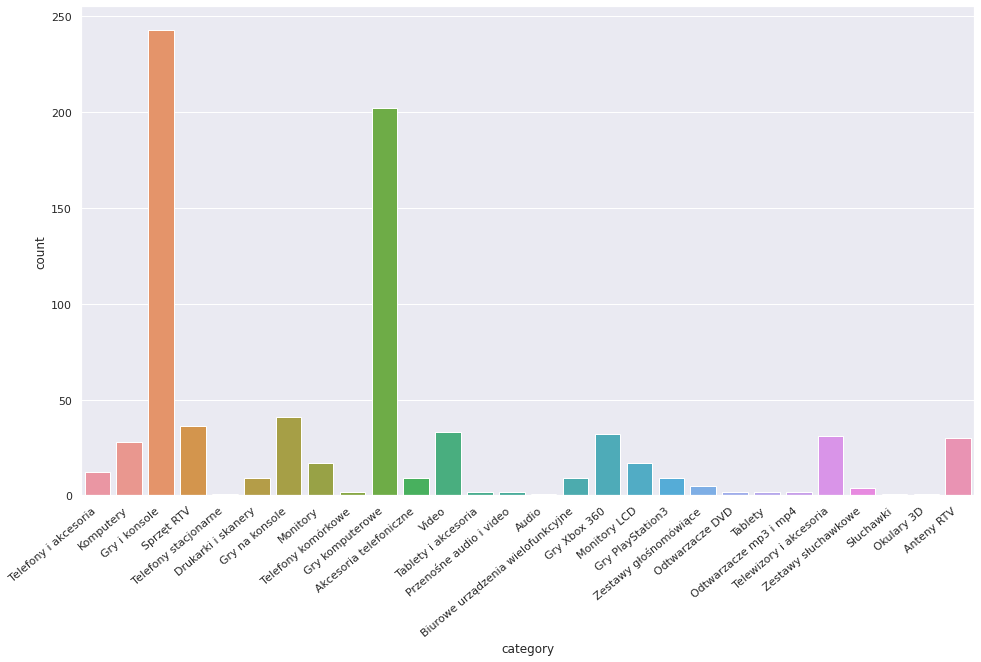

In [6]:
cp = sns.countplot(x='category', orient='v', data=categories.melt(var_name='columns', value_name='category'))
cp.set_xticklabels(cp.get_xticklabels(), rotation=40, ha="right")
cp

Jak widać na powyższym wykresie, sklep oferuje wiele kategorii produktów, jednak więszkość z nich zalicza się "gier i konsol" i/lub "gier komputerowych". Niepokojąca jest jednak obecność w tanych takich produktów, których ceny są wyższe niż 10mln złotych - raczej jest to błąd i należy to dodatkowo przeanalizować, by móc właściwie obsłużyć takie wpisy.

## Sesje

In [7]:
sessions = pd.read_json('data/sessions.jsonl', lines=True).astype({'event_type': 'str'})
sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-01-17 16:08:57,102.0,1001.0,VIEW_PRODUCT,0,NaN
1,100002,2020-01-07 05:10:41,102.0,1277.0,VIEW_PRODUCT,20,NaN
2,100002,2020-01-07 05:14:26,102.0,1276.0,VIEW_PRODUCT,20,NaN
3,100003,2020-01-16 09:37:42,102.0,1276.0,VIEW_PRODUCT,0,NaN
4,100003,2020-01-16 09:38:22,102.0,1277.0,VIEW_PRODUCT,0,NaN


### Przegląd produktów vs kupno

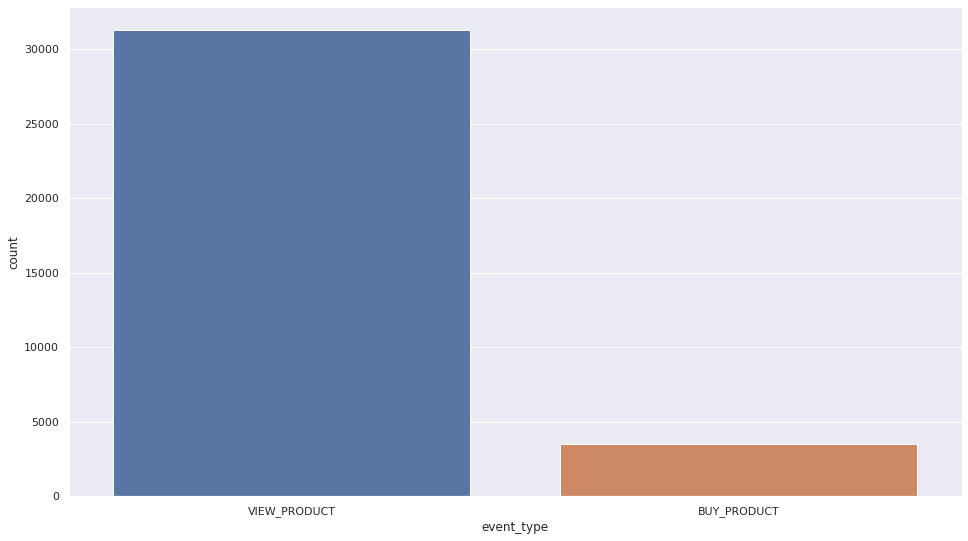

In [8]:
sns.countplot(x='event_type', data=sessions)

### Rozkład sesji w czasie

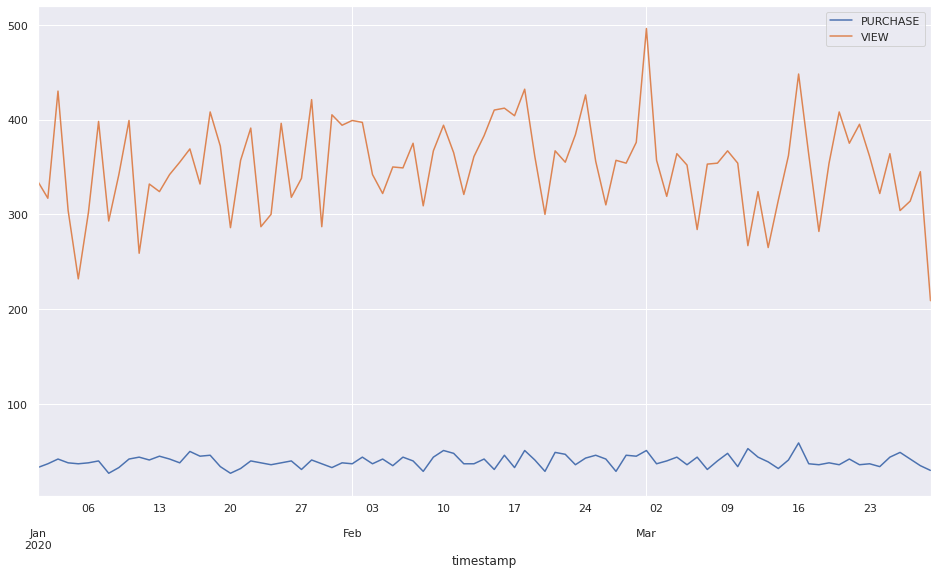

In [9]:
times = sessions[['event_type']]
times = pd.concat([pd.to_datetime(sessions.timestamp).apply(lambda t: t.date()), times], axis=1)
times = times.groupby(['timestamp', 'event_type']).size().reset_index().pivot(columns='event_type', index='timestamp')
times.columns = ['PURCHASE', 'VIEW']
times.plot()

### Sesje zakończone zakupem

In [10]:
len(sessions[sessions.event_type == 'BUY_PRODUCT'].session_id.unique())

3533

In [11]:
len(sessions.session_id.unique())

10076

Sesje są bardzo ważnym źródłem informacji, które pomoże nam lepiej zrozumieć zachowanie użytkowników w sklepie.
Zapisane zdarzenia to w większości przeglądanie produktów, jednak część z nich to zamówienia. Aktywność użytkowników jest w miarę stała w czasie (przy założeniu, że dane prezentują wycinek logów od początku stycznia do końca marca).
Niestety jedynie 35% sesji zakończyła się (wiązała się) z zakupem.

## Dostawy

In [12]:
deliveries = pd.read_json('data/deliveries.jsonl', lines=True)
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-01-13T00:29:10,2020-01-17T00:31:53,516.0
1,20002,2020-02-04T19:09:12,2020-02-06T19:13:06,516.0
2,20003,2020-01-16T14:40:39,2020-01-18T14:41:27,620.0
3,20004,2020-02-05T08:08:59,None,360.0
4,20005,2020-02-18T09:27:06,2020-02-21T09:31:35,620.0


### Czas dostawy

In [13]:
deliveries['purchase_timestamp'] = pd.to_datetime(deliveries.purchase_timestamp)
deliveries['delivery_timestamp'] = pd.to_datetime(deliveries.delivery_timestamp)
deliveries['time'] = deliveries['delivery_timestamp'] - deliveries['purchase_timestamp']
deliveries['time'].median()

Timedelta('4 days 00:00:14.500000')

Czas dostawy stanowi istotny czynnik warunkujący poziom zadowolenia użytkownika z zakupów. W przypadku tego sklepu, średni czas dostawy wynosi 3.5 dnia, mediana - ok 4 dni, a maksimum aż 5 dni. Dane dotyczące dostaw mogą okazać się cenne w przypadku przewidywania przyszłego zachowania powracających klientów.

## Całość

In [14]:
merged = pd.read_json('data/merged.jsonl', lines=True)
df = merged.categories.apply(pd.Series)
df = df.rename(columns = lambda x : 'cat_' + str(x))
merged = pd.concat([merged, df], axis=1).drop('categories', axis=1)
merged.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,made_purchase,product_name,price,...,city,street,purchase_timestamp,delivery_timestamp,delivery_company,delivery_time,cat_0,cat_1,cat_2,cat_3
0,100001,2020-01-17 16:08:57,102.0,1001,VIEW_PRODUCT,0,NaN,False,Telefon Siemens Gigaset DA310,58.97,...,Warszawa,plac Krakowska 69,NaN,NaN,NaN,NaT,Telefony i akcesoria,Telefony stacjonarne,NaN,NaN
1,100002,2020-01-07 05:10:41,102.0,1277,VIEW_PRODUCT,20,NaN,False,Apple iPad mini 64GB 4G,2317.02,...,Warszawa,plac Krakowska 69,NaN,NaN,NaN,NaT,Komputery,Tablety i akcesoria,Tablety,NaN
2,100002,2020-01-07 05:14:26,102.0,1276,VIEW_PRODUCT,20,NaN,False,Apple iPad mini 64GB,1816.97,...,Warszawa,plac Krakowska 69,NaN,NaN,NaN,NaT,Komputery,Tablety i akcesoria,Tablety,NaN
3,100003,2020-01-16 09:37:42,102.0,1276,VIEW_PRODUCT,0,NaN,False,Apple iPad mini 64GB,1816.97,...,Warszawa,plac Krakowska 69,NaN,NaN,NaN,NaT,Komputery,Tablety i akcesoria,Tablety,NaN
4,100003,2020-01-16 09:38:22,102.0,1277,VIEW_PRODUCT,0,NaN,False,Apple iPad mini 64GB 4G,2317.02,...,Warszawa,plac Krakowska 69,NaN,NaN,NaN,NaT,Komputery,Tablety i akcesoria,Tablety,NaN


### Skąd kupowane są produkty?

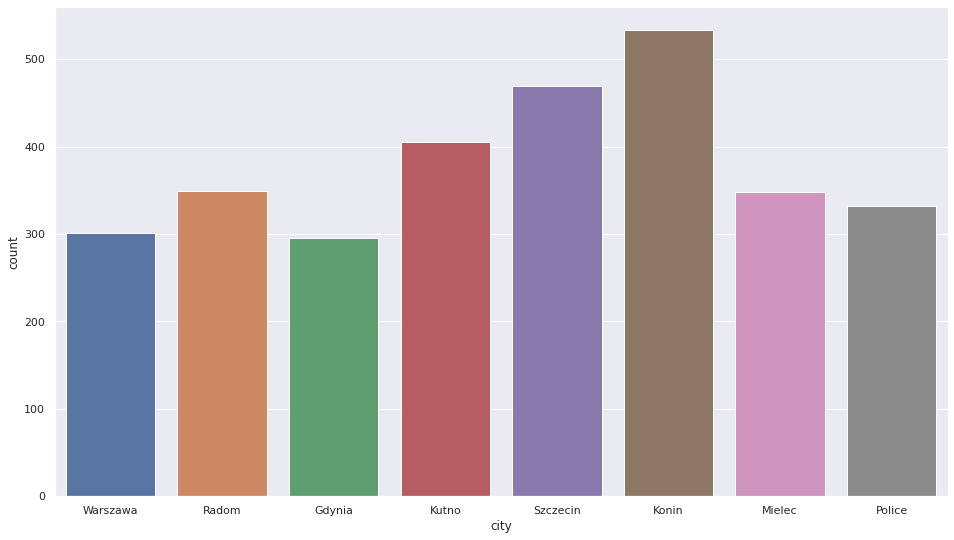

In [15]:
sns.countplot(x='city', data=merged[merged.made_purchase])

Miastami, z których pochodzi najwięcej zamówień jest Konin, Szczecin oraz Kutno. 

### Które kategorie produktów są najchętniej wybierane przez użytkowników?

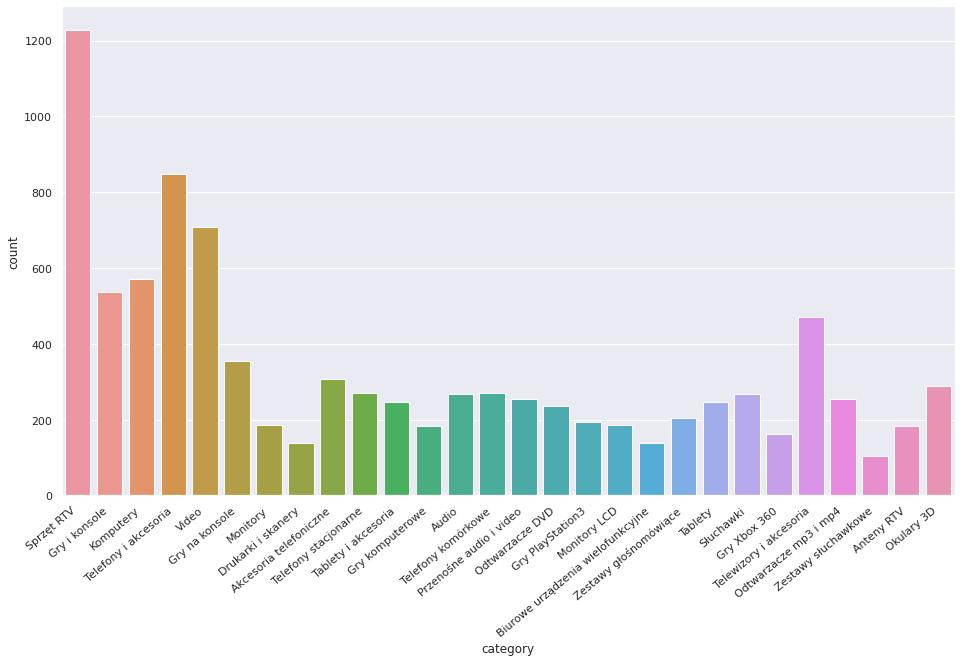

In [16]:
df = merged[merged.made_purchase][['cat_0','cat_1','cat_2','cat_3']]
df = df.melt(var_name='columns', value_name='category')
cp = sns.countplot(x='category', orient='v', data=df)
cp.set_xticklabels(cp.get_xticklabels(), rotation=40, ha="right")
cp

Mimo, że sprzęt RTV stanowi mały procent asortymentu sklepu, użytkownicy najczęściej wybierają właśnie te produkty w swoich zakupach.

# Wnioski końcowe

Dostarczone dane mogłyby być rozszerzone o czas zakończenia zdarzenia w sesji tak, aby była możliwość oceny długości tego zdarzenia. Będzie stanowiło to źródło informacji, na przykład o tym, jak dużo czasu użytkownik poświęcił na analizę danego produktu, co być może ma przełożenie na poziom zainteresowania tym produktem.

Poza tym, wszystkie dane są spójne i potencjalnie przydatne w zadaniu.